### Part 1:  Sentiment Classification using machine learning models (SVM, Decision Tree and Random Forest) and Bert Embeddings

In [59]:
# importing important libraries and functions
import re
import string
import nltk
import textblob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, precision_score, recall_score
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import transformers as ppb

In [2]:
# Downloading the nltk packages
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Loading the data
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv', index_col = [0])
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
# checking the shape of the dataset
data.shape

(23486, 10)

In [5]:
# Let's check the unique features in the dataset
data.nunique()

Clothing ID                 1206
Age                           77
Title                      13993
Review Text                22634
Rating                         5
Recommended IND                2
Positive Feedback Count       82
Division Name                  3
Department Name                6
Class Name                    20
dtype: int64

In [6]:
# Let's check the summary statistics of the dataset
data.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,918.118709,43.198544,4.196032,0.822362,2.535936
std,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


In [7]:
# Let's keep only Title, Review Text and Rating columns as only those are required in this study
data_df = data[['Title', 'Review Text', 'Rating']]
data_df.head()

,Title,Review Text,Rating
0,NaN,Absolutely wonderful - silky and sexy and comf...,4
1,NaN,Love this dress! it's sooo pretty. i happene...,5
2,Some major design flaws,I had such high hopes for this dress and reall...,3
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5
4,Flattering shirt,This shirt is very flattering to all due to th...,5


In [8]:
# Let's check the missing values in percentage
data_df.isnull().sum()/len(data_df)*100

Title          16.222430
Review Text     3.597888
Rating          0.000000
dtype: float64

In [9]:
# Let's check the missing values count
data_df.isnull().sum()

Title          3810
Review Text     845
Rating            0
dtype: int64

In [10]:
# drop rows where there is no review given by the customer
data_df = data_df[~data_df['Review Text'].isnull()]
data_df.shape

(22641, 3)

In [11]:
# Now, let's see how many records have title missing
data_df.loc[data_df['Title'].isnull()].shape

(2966, 3)

In [12]:
# Let's view such records that have missing titles
data_df.loc[data_df['Title'].isnull()].head()

,Title,Review Text,Rating
0,NaN,Absolutely wonderful - silky and sexy and comf...,4
1,NaN,Love this dress! it's sooo pretty. i happene...,5
11,NaN,This dress is perfection! so pretty and flatte...,5
30,NaN,Beautifully made pants and on trend with the f...,5
36,NaN,This is a comfortable skirt that can span seas...,4


In [13]:
# Let's check the info
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 3 columns):
Title          19675 non-null object
Review Text    22641 non-null object
Rating         22641 non-null int64
dtypes: int64(1), object(2)
memory usage: 707.5+ KB


In [14]:
# Generating a new column 'Review' by clubbing together columns 'Title' and 'Review Text' if the Title column is not blank
# otherwise keeping only the 'Review Text' column value
data_df['Review'] = np.where(data_df['Title'].isnull(), data_df['Review Text'], data_df['Title'] + ' ' + data_df['Review Text'])
data_df.head()

,Title,Review Text,Rating,Review
0,NaN,Absolutely wonderful - silky and sexy and comf...,4,Absolutely wonderful - silky and sexy and comf...
1,NaN,Love this dress! it's sooo pretty. i happene...,5,Love this dress! it's sooo pretty. i happene...
2,Some major design flaws,I had such high hopes for this dress and reall...,3,Some major design flaws I had such high hopes ...
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,"My favorite buy! I love, love, love this jumps..."
4,Flattering shirt,This shirt is very flattering to all due to th...,5,Flattering shirt This shirt is very flattering...


In [15]:
# dropping the 'Title' and 'Review Text' columns
data_df = data_df.drop(['Title', 'Review Text'], axis=1)
data_df.head()

,Rating,Review
0,4,Absolutely wonderful - silky and sexy and comf...
1,5,Love this dress! it's sooo pretty. i happene...
2,3,Some major design flaws I had such high hopes ...
3,5,"My favorite buy! I love, love, love this jumps..."
4,5,Flattering shirt This shirt is very flattering...


In [16]:
# Let's check the shape again
data_df.shape

(22641, 2)

In [17]:
# Let's create a new column capturing the type of sentiment of the review as positive or negative. Map rating of 4 and 5 as
# positive and ratings less than equal to 3 as negative as we are handling binary sentiment classification here.
data_df['Sentiment'] = np.where(data_df['Rating']>3, 'Positive', 'Negative')
data_df.head()

,Rating,Review,Sentiment
0,4,Absolutely wonderful - silky and sexy and comf...,Positive
1,5,Love this dress! it's sooo pretty. i happene...,Positive
2,3,Some major design flaws I had such high hopes ...,Negative
3,5,"My favorite buy! I love, love, love this jumps...",Positive
4,5,Flattering shirt This shirt is very flattering...,Positive


In [18]:
# Mapping the categorical text to numeric or binary i.e. 1 for Positive and 0 for Negative
sentiment_type = {"Positive": 1, "Negative": 0}
data_df['Sentiment'] = data_df['Sentiment'].map(sentiment_type)
data_df.head()

,Rating,Review,Sentiment
0,4,Absolutely wonderful - silky and sexy and comf...,1
1,5,Love this dress! it's sooo pretty. i happene...,1
2,3,Some major design flaws I had such high hopes ...,0
3,5,"My favorite buy! I love, love, love this jumps...",1
4,5,Flattering shirt This shirt is very flattering...,1


In [19]:
# Let's check the unique values and their frequency in the Rating column
data_df['Rating'].value_counts()

5    12540
4     4908
3     2823
2     1549
1      821
Name: Rating, dtype: int64

In [20]:
# Let's see the frequency distribution of rating in %
data_df['Rating'].value_counts()/len(data_df) * 100

5    55.386246
4    21.677488
3    12.468531
2     6.841571
1     3.626165
Name: Rating, dtype: float64

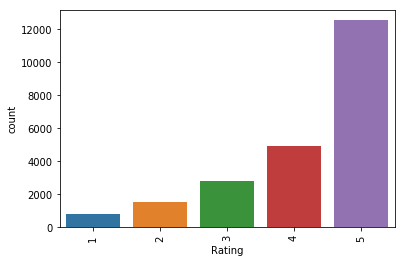

In [21]:
# Let's visualise and see
sns.countplot(x='Rating', data=data_df)
plt.xticks(rotation='vertical')
plt.show()

Data looks imbalanced as maximum are positive reviews i.e. with rating 4 and 5. Considering Rating <= 3 as negative and > 3 as positive. Let's randomly take 1000 reviews with rating 5, 1000 reviews with rating 4 and around 666 or 667 reviews with rating 1, 2 and 3 to make the data more balanced.

In [22]:
# Random sampling of records to make the distribution balanced
data_df5 = data_df[data_df['Rating'] == 5].sample(n=1000)
data_df4 = data_df[data_df['Rating'] == 4].sample(n=1000)
data_df3 = data_df[data_df['Rating'] == 3].sample(n=666)
data_df2 = data_df[data_df['Rating'] == 2].sample(n=667)
data_df1 = data_df[data_df['Rating'] == 1].sample(n=667)
data_final = pd.concat([data_df5, data_df4, data_df3, data_df2, data_df1])
data_final = data_final.sample(frac=1)
data_final.shape

(4000, 3)

In [23]:
# Let's view the new dataframe once
data_final.head()

,Rating,Review,Sentiment
12461,5,Love Just received this top in the mail & purc...,1
17075,1,#childsize. not sure where this went wrong but...,0
19188,1,"Neck The dress is pretty, i ordered a 4 and 6 ...",0
16967,3,Cropped How can some reviewers say this jacket...,0
18684,4,Fun way to floral up the closet! Looks cute on...,1


In [25]:
# Let's check the dataframe info again
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 12461 to 3655
Data columns (total 3 columns):
Rating       4000 non-null int64
Review       4000 non-null object
Sentiment    4000 non-null int64
dtypes: int64(2), object(1)
memory usage: 125.0+ KB


In [26]:
# TEXT CLEANING USING TextBlob spellchecker
# Text cleaning i.e. removal of punctuation marks, tokenization and conversion to lowercase

def text_cleaning(original_str):
    tokens = word_tokenize(original_str)
    clean_list1 = [word.lower() for word in tokens if word.isalpha()]
    clean_list = [''.join(TextBlob(word).correct()) if not wordnet.synsets(word) else word for word in clean_list1 ]
    clean_str = ' '.join(clean_list)
    return clean_str

In [27]:
# Applying text_cleaning function to Review column
data_final['Review'] = data_final['Review'].apply(text_cleaning)
data_final['Review'].head()

12461    love just received this top in the mail purcha...
17075    childlike not sure where this went wrong but i...
19188    neck the dress is pretty i ordered a and not k...
16967    cropped how can some reviewers say this jacket...
18684    fun way to floral up the closet looks cute on ...
Name: Review, dtype: object

In [28]:
# wordcloud function
stop=stopwords.words('english')
def wordcloud_display(input_df, color='white'):
    words = ' '.join(input_df)
    wordcloud = WordCloud(stopwords=stop,
                          background_color=color,
                          #width=2500,
                          #height=2500,
                          max_words=70
                         ).generate(words)
    plt.figure(1, figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

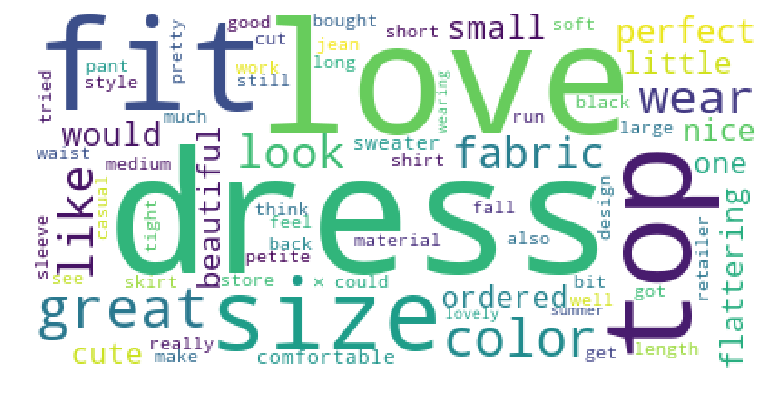

In [29]:
# print most frequent positive words
positive = data_final[data_final['Sentiment'] == 1]
positive = positive['Review']
wordcloud_display(positive, 'white')

So, we can see that the most frequent words used in positive reviews apart from the general words like dress, top etc. are love, great, like, perfect, comfortable, cute, beautiful, definitely, pretty, flattering etc.

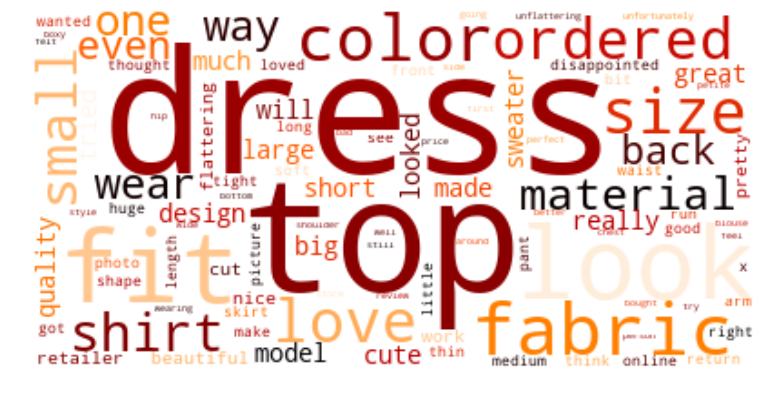

In [30]:
# print most frequent negative words
negative = data_final[data_final['Sentiment'] == 0]
negative = negative['Review']
wordcloud = WordCloud(background_color="white", max_words= 100, colormap='gist_heat')

wordcloud.generate(''.join(negative))

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Some of the frequent words used in negative reviews are unfortunately, however, disappointed, tight, large, small, short etc.

In [31]:
# Let's see few highly rated reviews
data_final[data_final['Rating'] == 5].head()

,Rating,Review,Sentiment
12461,5,love just received this top in the mail purcha...,1
3341,5,love love this so cute to have with additional...,1
9921,5,fabulous vest this vest kept catching my eye o...,1
17429,5,great pants these pants are as dreamy as linen...,1
12801,5,love this dress i ordered this dress in oatmea...,1


In [32]:
# Let's see few worst rated reviews
data_final[data_final['Rating'] == 1].sample(frac=1).head()

,Rating,Review,Sentiment
3833,1,cute design poor quality this is an adorable b...,0
9143,1,red got this in purple and love it ordered red...,0
1695,1,the material is cheap and looks torn not as ni...,0
17839,1,what a disappointment i should have read the r...,0
6678,1,sweater not as shown in photo much to my surpr...,0


In [33]:
# For BERT model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

I0126 14:37:47.123050 139770043279168 filelock.py:254] Lock 139765511850920 acquired on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

I0126 14:37:48.575721 139770043279168 filelock.py:317] Lock 139765511850920 released on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
I0126 14:37:49.337859 139770043279168 filelock.py:254] Lock 139765069672064 acquired on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.637c6035640bacb831febcc2b7f7bee0a96f9b30c2d7e9ef84082d9f252f3170.lock


Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

I0126 14:37:50.094457 139770043279168 filelock.py:317] Lock 139765069672064 released on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.637c6035640bacb831febcc2b7f7bee0a96f9b30c2d7e9ef84082d9f252f3170.lock
I0126 14:37:50.826022 139770043279168 filelock.py:254] Lock 139765069628304 acquired on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

I0126 14:37:59.676050 139770043279168 filelock.py:317] Lock 139765069628304 released on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock


In [34]:
# Let's tokenize the sentences i.e. break the sentences into words and subwords in a format that is expected by BERT
tokenized = data_final['Review'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [35]:
# Padding - pad all lists to the same size for easy representation in the form of a 2-D array
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [36]:
# max_len variable
print(max_len)

123


In [67]:
# Let's see the dimensions of the padded array
np.array(padded).shape

(4000, 122)

In [37]:
# Create a new variable to masks the padding that was added while processing the input
attn_mask = np.where(padded != 0, 1, 0)
attn_mask.shape

(4000, 123)

In [38]:
# Run the model
input_ids = torch.tensor(padded)  
attn_mask = torch.tensor(attn_mask)

with torch.no_grad():
    hidden_states = model(input_ids, attention_mask=attn_mask)

In [39]:
# Let's get the features to feed into our models
features = hidden_states[0][:,0,:].numpy()

In [40]:
# Labels indicating the polarity of the sentence i.e. positive or negative
labels = data_final['Sentiment']

In [41]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30)

In [54]:
# function for plotting ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

Training svm
Accuracy:  0.8116666666666666
Precision:  0.8153078202995009
Recall:  0.8099173553719008
F1 score:  0.8126036484245439
AUC-ROC: 0.900890339606917
Classification Report: 
              precision    recall  f1-score   support

          0       0.81      0.81      0.81       595
          1       0.82      0.81      0.81       605

avg / total       0.81      0.81      0.81      1200

Confusion Matrix: 
 [[484 111]
 [115 490]]


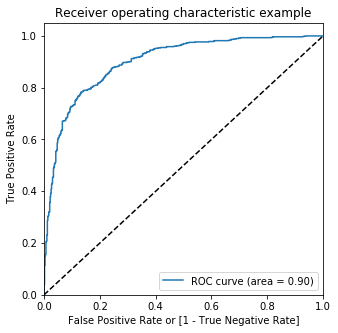


Training dt_cls
Accuracy:  0.675
Precision:  0.6831345826235093
Recall:  0.6628099173553719
F1 score:  0.6728187919463088
AUC-ROC: 0.6751024376692826
Classification Report: 
              precision    recall  f1-score   support

          0       0.67      0.69      0.68       595
          1       0.68      0.66      0.67       605

avg / total       0.68      0.68      0.67      1200

Confusion Matrix: 
 [[409 186]
 [204 401]]


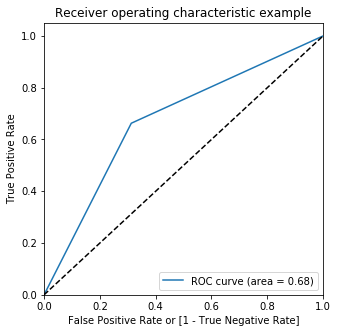


Training rf_cls
Accuracy:  0.7158333333333333
Precision:  0.7588235294117647
Recall:  0.6396694214876033
F1 score:  0.6941704035874439
AUC-ROC: 0.7954871866101813
Classification Report: 
              precision    recall  f1-score   support

          0       0.68      0.79      0.73       595
          1       0.76      0.64      0.69       605

avg / total       0.72      0.72      0.71      1200

Confusion Matrix: 
 [[472 123]
 [218 387]]


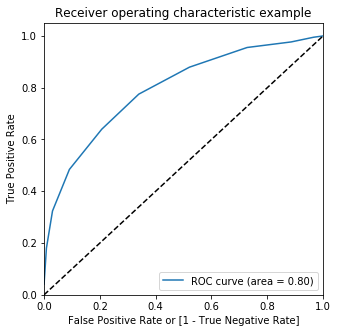

In [60]:
models = {
          'svm' : SVC(kernel='linear', probability=True), 'dt_cls' : DecisionTreeClassifier(), 'rf_cls' : RandomForestClassifier()
}
for model, call in models.items():
    print(f'Training {model}')
    call.fit(x_train, y_train)
    pred = call.predict(x_test)
    print("Accuracy: ", accuracy_score(y_test, pred))
    print("Precision: ", precision_score(y_test, pred))
    print("Recall: ", recall_score(y_test, pred))
    print("F1 score: ", f1_score(y_test, pred))
    print("AUC-ROC:", roc_auc_score(y_test, call.predict_proba(x_test)[:, 1]))
    print("Classification Report: \n", classification_report(y_test, pred))
    print("Confusion Matrix: \n", confusion_matrix(y_test, pred))
    draw_roc(y_test, call.predict_proba(x_test)[:, 1])
    print()

**Conclusion derived from the first part of the study**
* The performance of models was compared and evaluated based on evaluation metrics mentioned in this research such as accuracy, f1-score, recall, precision and auc-roc.
* Out of the machine learning models demonstrated above, Support Vector Machine gave the best performance with an auc-roc of 0.90, accuracy at 0.81, recall at 0.81, precision at 0.82 and f1-score at 0.81. Overall its looks like a good model.
* Decision Tree gave th worst performance comparatively with all scores in 0.67 to 0.68 range.
* Random Forest gave a good auc-roc of 0.80 though its less compared to SVM but still is a good enough value.